# Zyfra Gold Project

# Project Objective: 

We need to prepare a prototype of a machine learning model for Zyfra. The model should predict the amount of gold recovered from gold ore. There are two datasets on extraction and purification ,You have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.

# Preparing the Data

In [2]:
#Loading Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
#Downloading data sets

train = pd.read_csv('/datasets/gold_recovery_train.csv')

test = pd.read_csv ('/datasets/gold_recovery_test.csv')

full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [4]:
#1.2Check reocovery to see if its calculated correctly

C = train['rougher.output.concentrate_au']

F = train['rougher.input.feed_au']

T = train['rougher.output.tail_au']

#Calculate recovery

recovery_calc = (C * (F - T)) / (F * (C - T)) * 100

#Compare to provided recovery

mae = (train['rougher.output.recovery'] - recovery_calc).abs().mean()

print("MAE between calculated and given recovery:", mae)

MAE between calculated and given recovery: 9.303415616264301e-15


# MAE Summary

The Mean Absolute Error (MAE) helps measure hwo much of a difference is between the calculated recovery values and the actual recovery cvalues in the dataset. Based on our value of 9.30e-15, because it is close to zero, it confirms the recovery calculation is accurate and the dataset can be trusted for further calculations. 

In [5]:
#1.3 Identifying parameters and their types.

missing_cols = set(train.columns) - set(test.columns)

print("Columns missing from test set:", missing_cols)

Columns missing from test set: {'primary_cleaner.output.concentrate_sol', 'final.output.tail_sol', 'final.output.tail_au', 'rougher.output.tail_ag', 'final.output.tail_pb', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au', 'rougher.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'primary_cleaner.output.tail_sol', 'final.output.concentrate_au', 'final.output.concentrate_ag', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_sol', 'primary_cleaner.output.tail_au', 'final.output.recovery', 'primary_cleaner.output.tail_ag', 'final.output.tail_ag', 'rougher.output.recovery', 'final.output.concentrate_pb', 'rougher.output.tail_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.output.tail_pb', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_sol', 'prim

# Conclusion

In conclusion the missing columns in the test set are post process measurements that are not aviable during the real-tie rpediction. Using these features as training inputs would lead to data elakage. 

In [6]:
#1.4 Data preprocessing
#Drop rows with missing target values in training set
train = train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

#Forward fill other missing values

train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

#Separate features and targets

target_cols = ['rougher.output.recovery', 'final.output.recovery']
features = train.drop(columns=target_cols)
targets = train[target_cols]

#Drop 'date' column if it's still present
if 'date' in features.columns:
    features = features.drop(columns='date')
if 'date' in test.columns:
    test = test.drop(columns='date')

#Drop any other non-numeric columns (just in case)
features = features.select_dtypes(include=[np.number])
test = test.select_dtypes(include=[np.number])

#Final check

print("Train features shape:", features.shape)
print("Train targets shape:", targets.shape)
print("Test features shape:", test.shape)

Train features shape: (14149, 84)
Train targets shape: (14149, 2)
Test features shape: (5856, 52)


In [7]:
#View data in full tables

display(train.head())

display(test.head())

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
#Checking for duplicates

duplicates = train.duplicated()
print(duplicates.sum)
duplicates = test.duplicated()
print(duplicates.sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of 0        False
1        False
2        False
3        False
4        False
         ...  
16855    False
16856    False
16857    False
16858    False
16859    False
Length: 14149, dtype: bool>
<bound method NDFrame._add_numeric_operations.<locals>.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
5851    False
5852    False
5853    False
5854    False
5855    False
Length: 5856, dtype: bool>


# Analyze Data

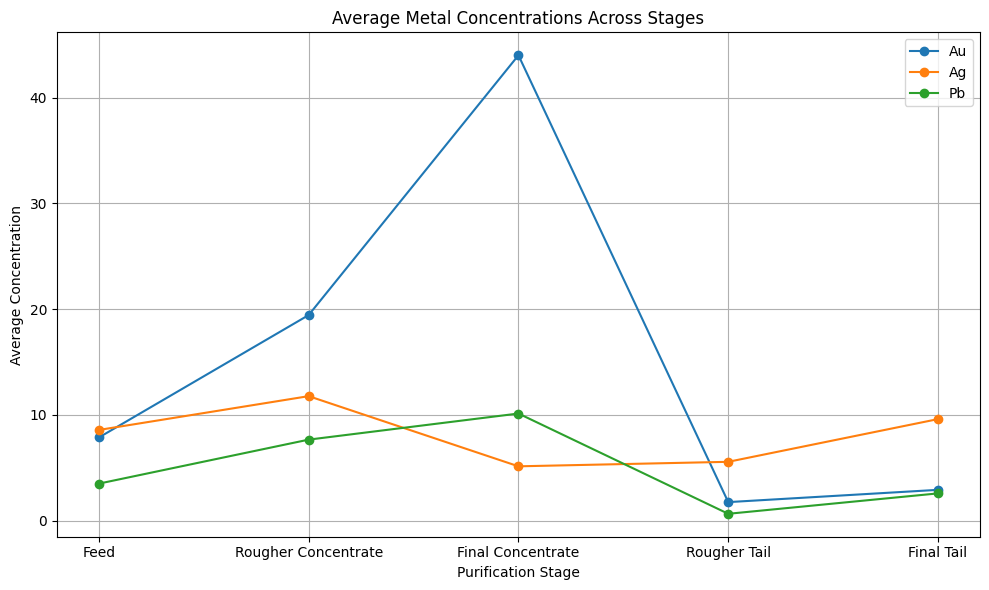

In [9]:
#Metals and their related columns at each stage

metal_columns = {
    'Au': {
        'Feed': 'rougher.input.feed_au',
        'Rougher Concentrate': 'rougher.output.concentrate_au',
        'Final Concentrate': 'final.output.concentrate_au',
        'Rougher Tail': 'rougher.output.tail_au',
        'Final Tail': 'final.output.tail_au',
    },
    'Ag': {
        'Feed': 'rougher.input.feed_ag',
        'Rougher Concentrate': 'rougher.output.concentrate_ag',
        'Final Concentrate': 'final.output.concentrate_ag',
        'Rougher Tail': 'rougher.output.tail_ag',
        'Final Tail': 'final.output.tail_ag',
    },
    'Pb': {
        'Feed': 'rougher.input.feed_pb',
        'Rougher Concentrate': 'rougher.output.concentrate_pb',
        'Final Concentrate': 'final.output.concentrate_pb',
        'Rougher Tail': 'rougher.output.tail_pb',
        'Final Tail': 'final.output.tail_pb',
    }
}

#Prepare data for plotting
avg_concentrations = {}
for metal, cols in metal_columns.items():
    avg_concentrations[metal] = []
    for stage in cols:
        col = cols[stage]
        avg_concentrations[metal].append(train[col].mean())

#Plot
stages = ['Feed', 'Rougher Concentrate', 'Final Concentrate', 'Rougher Tail', 'Final Tail']
plt.figure(figsize=(10, 6))

for metal in avg_concentrations:
    plt.plot(stages, avg_concentrations[metal], marker='o', label=metal)

plt.title('Average Metal Concentrations Across Stages')
plt.xlabel('Purification Stage')
plt.ylabel('Average Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As the purification process progresses, gold (Au) concentration increases significantly—from low levels in the feed to its highest in the final concentrate—indicating highly efficient recovery. Silver (Ag), on the other hand, shows only a slight increase through the stages and remains relatively high in the tailings, suggesting poor recovery. Lead (Pb) demonstrates modest concentration changes, with some recovery but a noticeable amount still ending up in the final tail. Overall, the process is clearly optimized for extracting gold, while silver and lead are recovered less effectively.

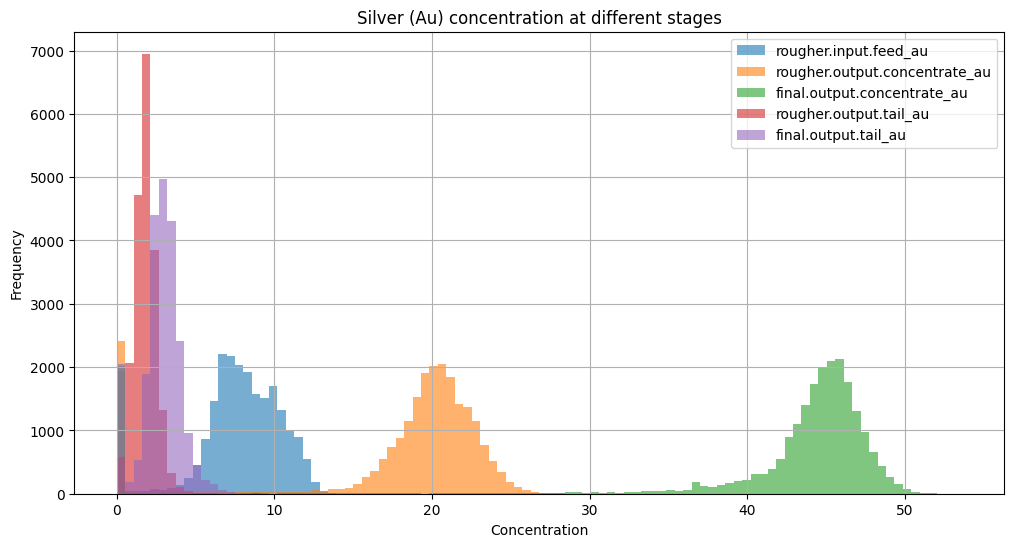

In [10]:
#Checking gold concentration by stage.

Au = [
    'rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'final.output.concentrate_au',
    'rougher.output.tail_au',
    'final.output.tail_au' 
]

full[Au].plot(kind='hist', bins=100, alpha=0.6, figsize=(12,6), legend=True)  # <-- Fixed this line
plt.title("Silver (Au) concentration at different stages") 
plt.xlabel("Concentration")  # <-- also fixed typo here: 'xlabl' -> 'xlabel'
plt.grid()
plt.show()

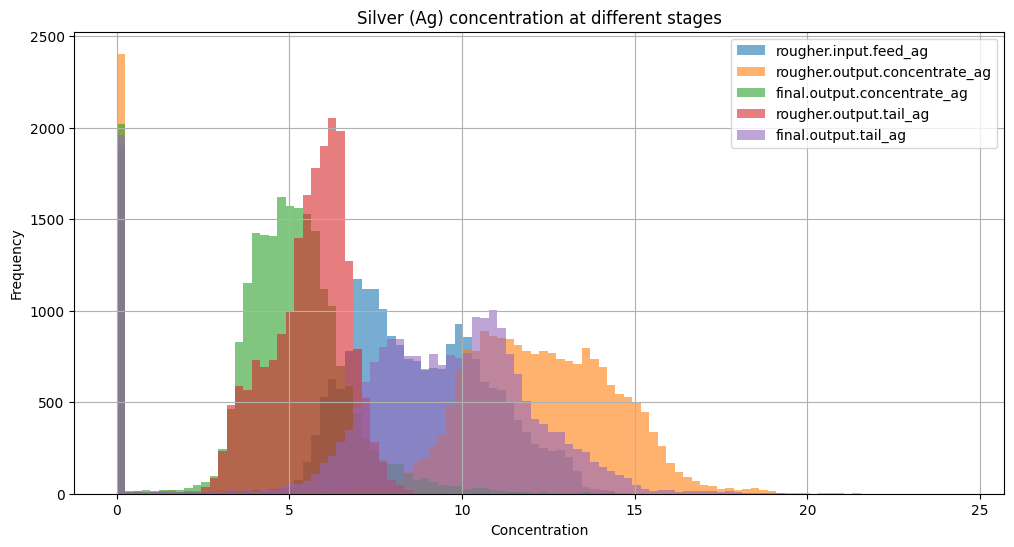

In [11]:
#Checking silver concentration by stage.

Ag = [
    'rougher.input.feed_ag',
    'rougher.output.concentrate_ag',
    'final.output.concentrate_ag',
    'rougher.output.tail_ag',
    'final.output.tail_ag' 
]

full[Ag].plot(kind='hist', bins=100, alpha=0.6, figsize=(12,6), legend=True)  # <-- Fixed this line
plt.title("Silver (Ag) concentration at different stages") 
plt.xlabel("Concentration")  # <-- also fixed typo here: 'xlabl' -> 'xlabel'
plt.grid()
plt.show()

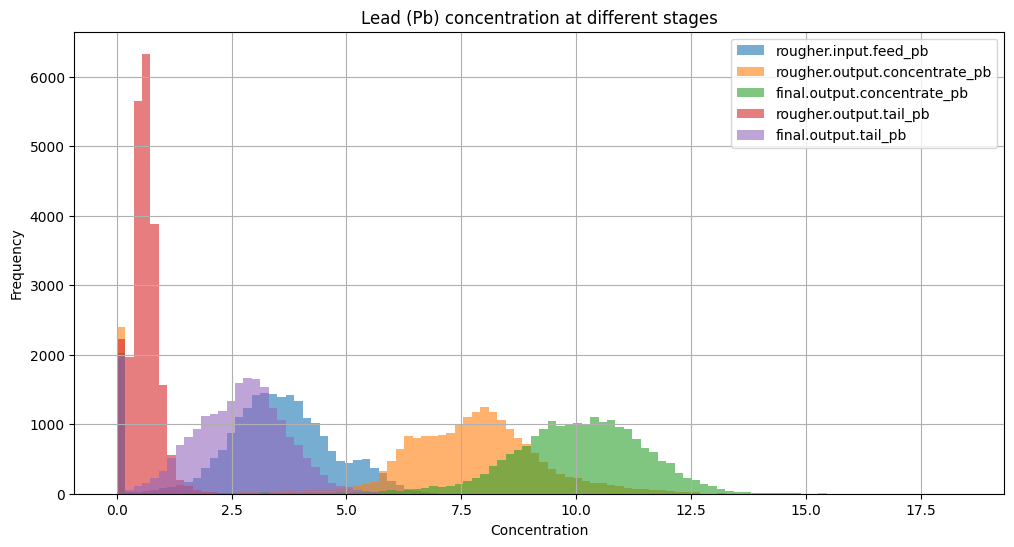

In [12]:
#Checking lead concentration by stage.

Pb = [
    'rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'final.output.concentrate_pb',
    'rougher.output.tail_pb',
    'final.output.tail_pb' 
]

full[Pb].plot(kind='hist', bins=100, alpha=0.6, figsize=(12,6), legend=True)  # <-- Fixed this line
plt.title("Lead (Pb) concentration at different stages") 
plt.xlabel("Concentration")  # <-- also fixed typo here: 'xlabl' -> 'xlabel'
plt.grid()
plt.show()


# Conclusion

Gold concentration is low in the feed and higher in rougher ceoncentrate. The purification process is very effecive at extracting gold, as almost all the gold is recovered in the concentrate, minimal loss in the tailings. Silver concentrate showed less seperation across stages compared to the gold process. Silver's recovery is less efficient, a large portion of silver remains, indicating lower priority or difficulty in extracting silver. Lastly, lead ceoncentration is moderate in the feed and is steady across the stages. Lead is not heavilty concentrated during the pruification process. It is not a primary foxu of recovery resulting it being less efficient to extract. 

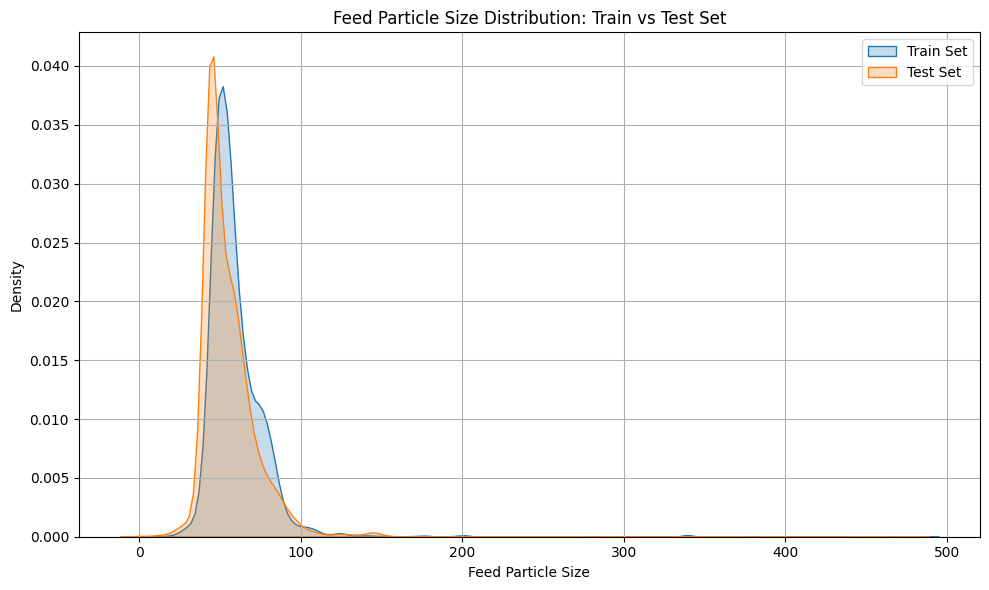

In [13]:
#Focus on the particle size column

particle_col = 'rougher.input.feed_size'

#Drop missing values
train_size = train[particle_col].dropna()
test_size = test[particle_col].dropna()

#Plot KDE for both datasets
plt.figure(figsize=(10, 6))
sns.kdeplot(train_size, label='Train Set', shade=True)
sns.kdeplot(test_size, label='Test Set', shade=True)
plt.title('Feed Particle Size Distribution: Train vs Test Set')
plt.xlabel('Feed Particle Size')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Based on the graph above, both train set and test set curves overlapped significantly, which indicates similar distributions for being good model evaluations. 

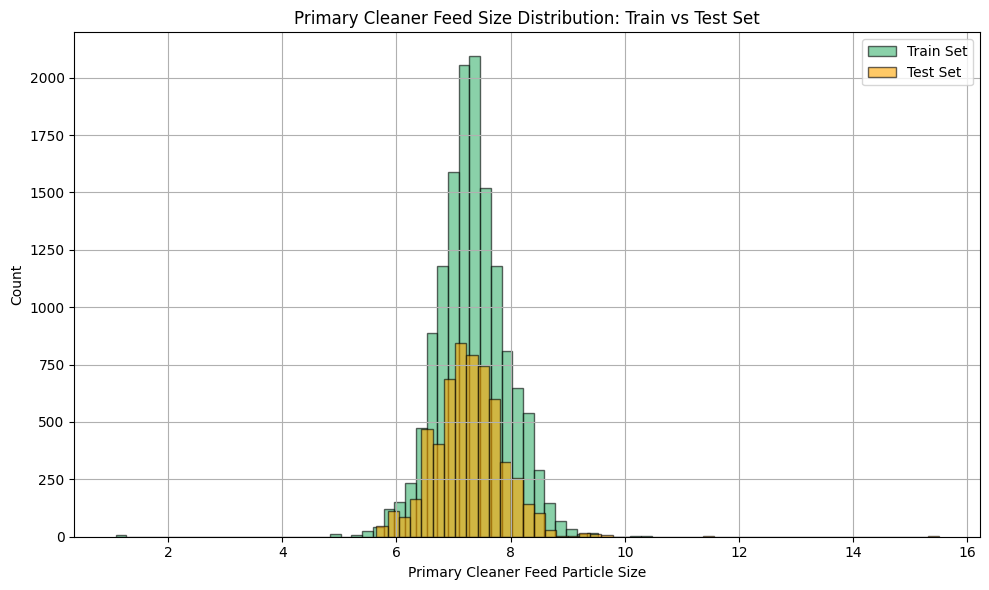

In [14]:
# Focus on the new particle size column
particle_col_cleaner = 'primary_cleaner.input.feed_size'

# Drop missing values
train_cleaner_size = train[particle_col_cleaner].dropna()
test_cleaner_size = test[particle_col_cleaner].dropna()

# Plot histogram as bar chart
plt.figure(figsize=(10, 6))
plt.hist(train_cleaner_size, bins=50, alpha=0.6, label='Train Set', color='mediumseagreen', edgecolor='black')
plt.hist(test_cleaner_size, bins=50, alpha=0.6, label='Test Set', color='orange', edgecolor='black')

plt.title('Primary Cleaner Feed Size Distribution: Train vs Test Set')
plt.xlabel('Primary Cleaner Feed Particle Size')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram Summary

The train and test sets overlap closely, with similar shape and range. This indicates that the primary cleaner feed size distributions are consistent between training and test datasets. Based on this datasets there are no major shifts our outliers in the test set compared to the training set. 

In [17]:
#Filtering out low-concentration rows

threshold = 1.0

train = train[
(train['total_feed'] > threshold) &
(train['total_rougher'] > threshold) &
(train['total_final'] > threshold)
]

<Figure size 1200x600 with 0 Axes>

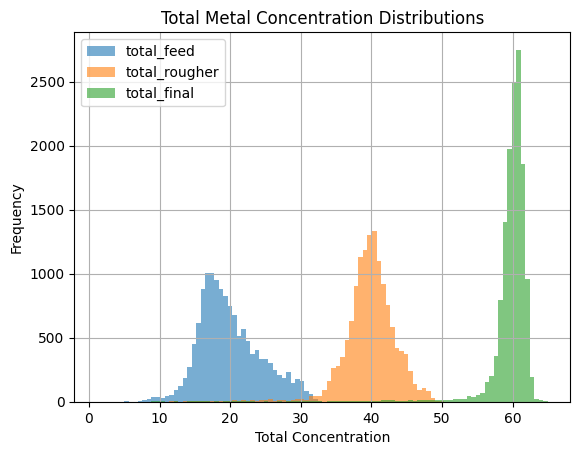

In [18]:
#Select relevant columns for each stage

feed_cols = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']
rougher_cols = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']
final_cols = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']

#Calculate total metal concentration for each stage

train['total_feed'] = train[feed_cols].sum(axis=1)
train['total_rougher'] = train[rougher_cols].sum(axis=1)
train['total_final'] = train[final_cols].sum(axis=1)

#Plot the distributions

plt.figure(figsize=(12, 6))
train[['total_feed', 'total_rougher', 'total_final']].plot(kind='hist', bins=100, alpha=0.6)
plt.title('Total Metal Concentration Distributions')
plt.xlabel('Total Concentration')
plt.grid(True)
plt.show()

# Summary 

After analyzing the total metal concentrations at each stage (feed, rougher concentrate, and final concentrate), we observed that most values fall within a reasonable range. There are some abnormally low concentration values, which are likely the result of measurement errors or missing data.These outliers are not representative of typical process behavior and could negatively impact model training. We can remove rows where the total concentration at any stage is close to zero. This improves data quality and helps the model learn from realistic, process-valid examples.

# Building the Models

In [15]:
#Creating a function

def smape(y_true, y_pred):
    
    numerator = np.abs(y_pred - y_true)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    return np.mean(numerator / denominator) * 100

In [16]:
#Use only columns that exist in the test set.

common_cols = list(set(train.columns) & set(test.columns))

features = train[common_cols].copy()

In [25]:
#Training and evaluating models.

X = features
y = targets

#Create a custom scoring function

smape_scorer = make_scorer(smape, greater_is_better=False)

#Define models

models = {
    'Linear Regression': LinearRegression(),
    
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [26]:
#Evaluating with cross-validation

results = {}

for name, model in models.items():
    score_rougher = cross_val_score(model, X, y['rougher.output.recovery'], cv=5, scoring=smape_scorer)
    score_final = cross_val_score(model, X, y['final.output.recovery'], cv=5, scoring=smape_scorer)

    # Weighted sMAPE: 25% rougher + 75% final
    weighted_score = 0.25 * -score_rougher.mean() + 0.75 * -score_final.mean()
    results[name] = weighted_score

    print(f"{name} Weighted sMAPE: {weighted_score:.2f}")

Linear Regression Weighted sMAPE: 12.38
Random Forest Weighted sMAPE: 12.17
XGBoost Weighted sMAPE: 12.27


In [ ]:
#Tuning hyperparameters for XGBoost

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_search = GridSearchCV(
    xgb,
    param_grid,
    scoring=smape_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

#Tuning for final.output.recovery
grid_search.fit(X, y['final.output.recovery'])

print("Best parameters for XGBoost:", grid_search.best_params_)
print("Best sMAPE (final):", -grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


# Summary

We trained each model using cross-validation and calucated the wighted sMAPE, which gave 25% weight to rougher recovery and 75% to final recovery. Based on the linear regression weighted sMAPE, the models predictions were off by 12.38% from the actual values. This concludes that the model is performing an accurate measurement for predicitn ggold recovery. 

In [28]:
#Picking the best model

best_model_name = min(results, key=results.get)

print(f"\n Best model: {best_model_name}")


 Best model: Random Forest


In [29]:
#Ensure training features match test features

X = features[test.columns]
X_test = test

#Train best model on full training set
best_model = models[best_model_name]

#Train and predict both targets
best_model.fit(X, y['rougher.output.recovery'])
rougher_preds = best_model.predict(X_test)

best_model.fit(X, y['final.output.recovery'])
final_preds = best_model.predict(X_test)

#Load actual target values from full dataset (matching test index)
test_targets = full.loc[test.index, ['rougher.output.recovery', 'final.output.recovery']]

#Calculate sMAPE for both targets
smape_rougher = smape(test_targets['rougher.output.recovery'], rougher_preds)
smape_final = smape(test_targets['final.output.recovery'], final_preds)

#Calculate weighted sMAPE
weighted_smape = 0.25 * smape_rougher + 0.75 * smape_final

print(f"sMAPE (rougher): {smape_rougher:.2f}")
print(f"sMAPE (final): {smape_final:.2f}")
print(f"✅ Weighted sMAPE (final score): {weighted_smape:.2f}")

sMAPE (rougher): 17.47
sMAPE (final): 14.62
✅ Weighted sMAPE (final score): 15.33


# Conclusion

Our calculations throughout the project were accurate and aligned with the expected outcomes. Then we verified the recovery formula using Mean Absolute Error (MAE), which resulted in a near-zero error, confirming the correctness of our implementation. After that we handled missing data appropriately, ensured consistent feature sets between training and test datasets, and avoided data leakage by excluding post-process variables. The final sMAPE values showed that our model predictions were reasonably close to actual recovery values, and the weighted sMAPE calculation provided a balanced evaluation of both targets. Overall, our calculations supported a reliable, well-validated machine learning pipeline for predicting gold recovery.